# Supply Chain Analytics: Assignment 4 

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.|  Katja Tophoff      |     13378678         |     katja.tophoff@gmail.com   |
|2.|     Nicky Trijbits   |       12857815       |      ntrijbits@gmail.com   |
|3.|    Albin Lindqvist    |       13986236       |    albin.lindqvist@hotmail.se     |

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## From Assembly to Serial (and back)

**1. Convert the assembly system shown below to a serial supply chain. Make sure you specify: (i) the revised lead times and (ii) the revised local and echelon holding costs.** 

**2a. Apply the Shang-Song heuristic to find the right basestock policy (echelon type). Make sure you plot three curves: <br>
A. The approximative solution. <br>
L. The lower bound. <br>
U. The upper bound.** <br> 

In [18]:
def get_heuristic(
    stages: list[int],
    local_holding_costs: list[int],
    lead_times: list[int],
    penalty: int,
    mu: int,
    sigma: int,
) -> dict[int, dict[str, float]]:
    results = {stage: {} for stage in stages}
    for idx, stage in enumerate(stages):
        lead_time_scale = sum(lead_times[: idx + 1])
        lower_bound_ratio = (penalty + sum(local_holding_costs[idx + 1 :])) / (
            penalty + sum(local_holding_costs)
        )
        lower_bound = mu * lead_time_scale + norm.ppf(
            lower_bound_ratio
        ) * sigma * np.sqrt(lead_time_scale)
        upper_bound_ratio = (penalty + sum(local_holding_costs[idx + 1 :])) / (
            penalty + sum(local_holding_costs[idx:])
        )
        upper_bound = mu * lead_time_scale + norm.ppf(
            upper_bound_ratio
        ) * sigma * np.sqrt(lead_time_scale)
        results[stage]["upper"] = upper_bound
        results[stage]["lower"] = lower_bound
        results[stage]["approx"] = (upper_bound + lower_bound) / 2
    return results

In [ ]:
stages = [1, 2, 3]
echelon_holding_costs = [3, 4, 3]
lead_times = [1, 3, 1]
penalty = 37.12
mu = 5
sigma = 1
heuristic_results = get_heuristic(
    stages, echelon_holding_costs, lead_times, penalty, mu, sigma
)
for stage in stages:
    print(
        f"Stage {stage}: {heuristic_results[stage]['lower']} <= S^*_{stage} <= {heuristic_results[stage]['upper']}"
    )

Stage 1: 6.524697902398019 <= S^*_1 <= 6.524697902398019
Stage 2: 22.08528562902709 <= S^*_2 <= 22.673381131308336
Stage 3: 26.786009833884222 <= S^*_3 <= 28.222437836661367


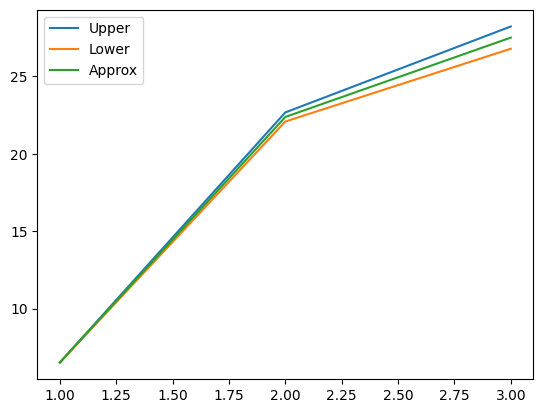

In [20]:
upper_bounds = [heuristic_results[stage]["upper"] for stage in stages[:3]]
lower_bounds = [heuristic_results[stage]["lower"] for stage in stages[:3]]
approx = [heuristic_results[stage]["approx"] for stage in stages[:3]]
plt.plot(stages[:3], upper_bounds, label="Upper")
plt.plot(stages[:3], lower_bounds, label="Lower")
plt.plot(stages[:3], approx, label="Approx")
plt.legend()

**2b. In addition, compute the exact solution (S) for each echelon and add it to the plot of 2a. Does it fall within the range outlined by the heuristic (i.e., between L and U)?**

In [21]:
from typing import Callable


def c_hat(holding_cost, last_c_under) -> Callable[[float], float]:
    return lambda x: holding_cost * x + last_c_under(x)


def c(c_hat_func, mu, sigma) -> Callable[[float], float]:
    def expected_value(y):
        return norm.expect(lambda x: c_hat_func(y - x), loc=mu, scale=sigma)

    return expected_value


def c_under(c_hat_func, S_star) -> Callable[[float], float]:
    return lambda x: c_hat_func(min(S_star, x))

In [22]:
from tqdm import tqdm


def get_exact(
    stages: list[int],
    local_holding_costs: list[int],
    lead_times: list[int],
    penalty: int,
    mu: int,
    sigma: int,
    use_heuristic: bool = False,
) -> dict[int, float]:
    C_under = {0: lambda x: max(0, -x) * (penalty + sum(local_holding_costs))}
    C_hat = {}
    C = {}
    S_star: dict[int, float] = {}
    if use_heuristic:
        heuristic_results = get_heuristic(
            stages, local_holding_costs, lead_times, penalty, mu, sigma
        )
    for idx, j in tqdm(enumerate(stages)):
        C_hat[j] = c_hat(local_holding_costs[idx], C_under[j - 1])
        lead_time_scale = sum(lead_times[: idx + 1])
        C[j] = c(C_hat[j], mu * lead_time_scale, sigma * np.sqrt(lead_time_scale))
        if use_heuristic:
            possible_y_values = np.linspace(
                heuristic_results[j]["lower"] - 1,
                heuristic_results[j]["upper"] + 1,
                101,
            )
        else:
            possible_y_values = np.linspace(0, 100, 51)
            # Get an estimate of S_star
            temp_S_star = possible_y_values[
                np.argmin([C[j](y) for y in possible_y_values])
            ]
            # Get more precise S_star
            possible_y_values = np.linspace(temp_S_star - 1, temp_S_star + 1, 101)
            temp_S_star = possible_y_values[
                np.argmin([C[j](y) for y in possible_y_values])
            ]
            possible_y_values = np.linspace(temp_S_star - 0.1, temp_S_star + 0.1, 101)
        S_star[j] = possible_y_values[np.argmin([C[j](y) for y in possible_y_values])]
        C_under[j] = c_under(C_hat[j], S_star[j])
    return S_star

In [ ]:
stages = [1, 2, 3]
echelon_holding_costs = [3, 4, 3]
lead_times = [1, 3, 1]
penalty = 37.12
mu = 5
sigma = 1
exact_results = get_exact(
    stages[:3], echelon_holding_costs, lead_times, penalty, mu, sigma, use_heuristic=False
)
exact_results

3it [00:43, 14.48s/it]


{1: np.float64(6.523999999999999),
 2: np.float64(22.092000000000002),
 3: np.float64(26.794)}

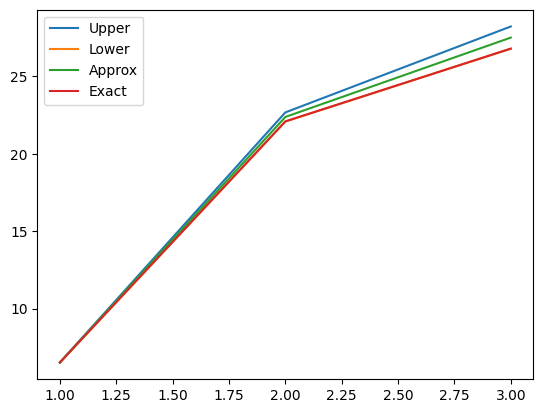

In [24]:
# Plot the exact values in comparison to the heuristic
upper_bounds = [heuristic_results[stage]["upper"] for stage in stages[:3]]
lower_bounds = [heuristic_results[stage]["lower"] for stage in stages[:3]]
approx = [heuristic_results[stage]["approx"] for stage in stages[:3]]
plt.plot(stages[:3], upper_bounds, label="Upper")
plt.plot(stages[:3], lower_bounds, label="Lower")
plt.plot(stages[:3], approx, label="Approx")
exact = [exact_results[stage] for stage in stages[:3]]
plt.plot(stages[:3], exact, label="Exact")
plt.legend()

It does fall within the bound, and it is right on the lower bound.

**2c. Convert the echelon-type policy to a local policy and apply it to the original assembly system. So, how much inventory one should try to keep at each stage (basestock levels)?**

In [34]:
# Local base stock levels of the exact solution
for stage in stages:
    last_stage = 0 if stage == 1 else exact_results[stage - 1]
    print(f"Stage {stage} S'^*_{stage} = {exact_results[stage] - last_stage}")

Stage 1 S'^*_1 = 6.523999999999999
Stage 2 S'^*_2 = 15.568000000000003
Stage 3 S'^*_3 = 4.701999999999998


**2d. Here, we converted an assembly system to an ‘equivalent’ serial system. Can we apply a similar trick for a distribution system? Explain in words how or why we cannot.**

## Simulating the Bullwhip Effect: Demand Signalling

**3a. For α = 0.8, plot the customer demand Di and orders of the retailer and manufacturer QRET,i and QMAN,i. So, three curves in total for one round, a round consisting of 50 days. Do you observe a bullwhip effect?**

In [25]:
from abc import ABC, abstractmethod
from typing import Callable


class Stage(ABC):
    def __init__(
        self, name: str, inventory: float, in_coming_level: float, lead_time: int
    ) -> None:
        self.name = name
        self.inventory = inventory
        self.total_orders = 0
        self.in_coming = [in_coming_level for _ in range(max(lead_time, 1))]

    # 1. Check delivery
    def check_delivery(self):
        self.inventory += self.in_coming.pop(0)

    # 2. Check orders
    def check_order(self, order: float):
        self.total_orders += order

    # 3. Deliver order -> go to transit in next stage
    def deliver_order(self) -> float:
        out = min(self.total_orders, self.inventory)
        self.total_orders -= out
        self.inventory -= out
        return out

    # 4. Make order decision
    @abstractmethod
    def make_order_decision(self) -> float: ...

    # 5. Add in transit items
    def add_in_transit(self, order: float):
        self.in_coming.append(order)

    def go_forward(self, order: float) -> tuple[float, float]:
        self.check_delivery()
        self.check_order(order)
        delivery = self.deliver_order()
        order = self.make_order_decision()
        return delivery, order

    def __repr__(self) -> str:
        return f"Stage(name={self.name:<20}, inventory={self.inventory:<15.1f}, total_orders={self.total_orders:<3.1f}, in_coming={self.in_coming})"


class BeerGame:
    def __init__(
        self,
        stage_class: type[Stage],
        weeks: int = 52,
        initial_stock: float = 20,
        demand_function: Callable[[], float] = lambda: np.random.normal(20, 4),
        lead_time: int = 4,
        **kwargs,
    ):
        self.weeks = weeks
        self.initial_stock = initial_stock
        self.demand_function = demand_function
        self.infinite_supplier = stage_class("Infinite Supplier", 1e10, 0, 0, **kwargs)
        self.manufacturer = stage_class(
            "Manufacturer", initial_stock, 20, lead_time, **kwargs
        )
        self.retailer = stage_class("Retailer", initial_stock, 20, lead_time, **kwargs)
        self.lead_time = lead_time

    def go_forward(self):
        demand = self.demand_function()

        # Step 1
        self.infinite_supplier.check_delivery()
        self.manufacturer.check_delivery()
        self.retailer.check_delivery()

        # Step 2
        self.retailer.check_order(demand)
        self.retailer.deliver_order()
        retailer_order = self.retailer.make_order_decision()

        self.manufacturer.check_order(retailer_order)
        man_produced = self.manufacturer.deliver_order()
        manufacturer_order = self.manufacturer.make_order_decision()
        self.retailer.add_in_transit(man_produced)

        self.infinite_supplier.check_order(manufacturer_order)
        inf_produced = self.infinite_supplier.deliver_order()
        self.manufacturer.add_in_transit(inf_produced)
        self.infinite_supplier.add_in_transit(
            self.infinite_supplier.make_order_decision()
        )

        return demand, retailer_order, manufacturer_order

    def simulate(self):
        simulation = {}
        for week in range(self.weeks):
            demand, retailer, manufacturer = self.go_forward()
            simulation[week] = {
                "demand": demand,
                "retailer_order": retailer,
                "manufacturer_order": manufacturer,
            }
            simulation[week]["infinite_supplier_inventory"] = (
                self.infinite_supplier.inventory
            )
            simulation[week]["infinitely_supplier_orders"] = (
                self.infinite_supplier.total_orders
            )
            simulation[week]["manufacturer_inventory"] = self.manufacturer.inventory
            simulation[week]["manufacturer_orders"] = self.manufacturer.total_orders
            simulation[week]["retailer_inventory"] = self.retailer.inventory
            simulation[week]["retailer_orders"] = self.retailer.total_orders

        return simulation

    @staticmethod
    def bullwhip_effect(sim):
        days = list(sim.keys())
        retailer_inventory = [sim[day]["retailer_order"] for day in days]
        manufacturer_inventory = [sim[day]["manufacturer_order"] for day in days]
        demand_inventory = [sim[day]["demand"] for day in days]
        return np.var(retailer_inventory) / np.var(demand_inventory), np.var(
            manufacturer_inventory
        ) / np.var(demand_inventory)

    def visualise_simulation(self, simulation):
        days = list(simulation.keys())
        demand = [simulation[day]["demand"] for day in days]
        retailer_order = [simulation[day]["retailer_order"] for day in days]
        manufacturer_order = [simulation[day]["manufacturer_order"] for day in days]
        # infinitely_supplier_orders = [simulation[day]["infinitely_supplier_orders"] for day in days]
        plt.plot(days, demand, label="Demand")
        plt.plot(days, retailer_order, label="Retailer Order")
        plt.plot(days, manufacturer_order, label="Manufacturer Order")
        plt.legend()

    def __repr__(self):
        return f"BeerGame(weeks={self.weeks}, initial_stock={self.initial_stock}, demand_function={self.demand_function}, lead_time={self.lead_time})\n{self.infinite_supplier}\n{self.manufacturer}\n{self.retailer}"

In [26]:
class RandomStage(Stage):
    def __init__(
        self, name: str, inventory: float, in_coming_level: float, lead_time: int
    ) -> None:
        super().__init__(name, inventory, in_coming_level, lead_time)
        self.last_order = in_coming_level

    def check_order(self, order: float):
        self.last_order = order
        return super().check_order(order)

    def make_order_decision(self) -> float:
        if self.last_order > 20:
            return self.total_orders / 4 * np.random.uniform(0.9, 1.3)
        return self.total_orders / 4 * np.random.uniform(0.4, 1.1)

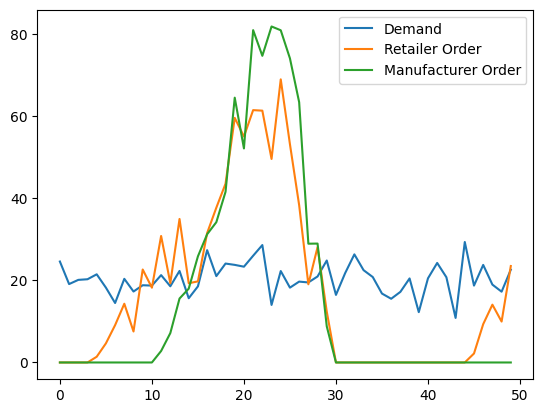

In [27]:
# Make sure it works, we react to the demand observe by ordering by the number of orders that we have recieved and not yet delivered
# We are looking at wheter or not we are observing the bullwhip effect (especially for the manufacturer)
rand_bg = BeerGame(RandomStage, weeks=50)
rand_sim = rand_bg.simulate()
rand_bg.visualise_simulation(rand_sim)

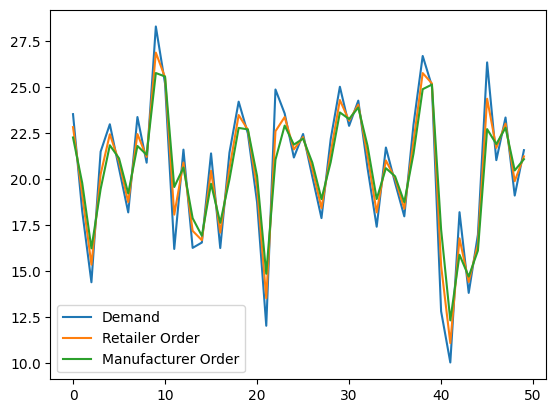

In [28]:
class ExponentialSmoothingStage(Stage):
    def __init__(
        self,
        name: str,
        inventory: float,
        in_coming_level: float,
        lead_time: int,
        alpha: float = 0.8,
    ) -> None:
        super().__init__(name, inventory, in_coming_level, lead_time)
        self.alpha = alpha
        self.forecast = inventory

    def check_order(self, order: float):
        self.forecast = self.alpha * order + (1 - self.alpha) * self.forecast
        return super().check_order(order)

    def make_order_decision(self) -> float:
        return self.forecast


exp_bg = BeerGame(ExponentialSmoothingStage, weeks=50)
exp_sim = exp_bg.simulate()
exp_bg.visualise_simulation(exp_sim)

**3b. Are demand fluctuations amplified? Name and compute a metric that quantifies the size of the bullwhip effect per stage, if there is one.**

Since the bullwhip effect causes a big deviation from the mean we will use the variance of the demand and the order levels. The ratio of 
$\\tilde{b}=\\frac{\\text{Var}(\\text{manufacturer order size})}{\\text{Var}(\\text{demand})}$ (similar for Retailer) will show wheter or not we have a bullwhip effect if the ratio is $\\tilde{b}\\gg 1$. Below we have emperical proof that the metric works, by seeing that in the random stage strategy we have a much higher ratio compared to the exponential smoothing.\n",
    "\n",
    "The demand fluctations do not get amplified with the exponential smoothing for the different stages, this is because they are reacting rationally to the changes in demand.

Since the bullwhip effect causes a significant deviation from the mean, we will use the variance of the demand and the order levels. The ratio of 

$$
\tilde{b} = \frac{\text{Var}(\text{manufacturer order size})}{\text{Var}(\text{demand})}
$$

(similarly for the retailer) will indicate whether or not we have a bullwhip effect. If the ratio is $ \tilde{b} \gg 1 $
the bullwhip effect is present.

Below, we provide empirical proof that this metric works, as the random stage strategy exhibits a much higher ratio compared to exponential smoothing.

The demand fluctuations do not get amplified with exponential smoothing across the different stages. This is because the stages react rationally to changes in demand, effectively dampening the amplification.

In [29]:
b_tilde = exp_bg.bullwhip_effect(exp_sim)
print(
    f"RandomStage bullwhip effect: Retailer: {b_tilde[0]:.2f}, Manufacturer: {b_tilde[1]:.2f}"
)

RandomStage bullwhip effect: Retailer: 0.71, Manufacturer: 0.54


In [30]:
b_tilde = rand_bg.bullwhip_effect(rand_sim)
print(
    f"RandomStage bullwhip effect: Retailer: {b_tilde[0]:.2f}, Manufacturer: {b_tilde[1]:.2f}"
)

RandomStage bullwhip effect: Retailer: 28.33, Manufacturer: 47.30


**3c. Repeat the procedure of 3a a hundred times. Over these runs and the impact α has (for several α settings, rerun the experiment). Plot the impact of α on your metrics that quantify the bullwhip effect.**

In [31]:
alpha_values = np.linspace(0, 1, 101)
bullwhip_effect = {
    (alpha, stage): []
    for alpha in alpha_values
    for stage in ["retailer", "manufacturer"]
}
for alpha in alpha_values:
    for _ in range(100):
        exp_bg = BeerGame(ExponentialSmoothingStage, weeks=50, alpha=alpha)
        sim = exp_bg.simulate()
        b_tilde = exp_bg.bullwhip_effect(sim)
        bullwhip_effect[alpha, "retailer"].append(b_tilde[0])
        bullwhip_effect[alpha, "manufacturer"].append(b_tilde[1])

Text(0.5, 1.0, 'Bullwhip effect ($\\tilde{b}$) for different alpha values')

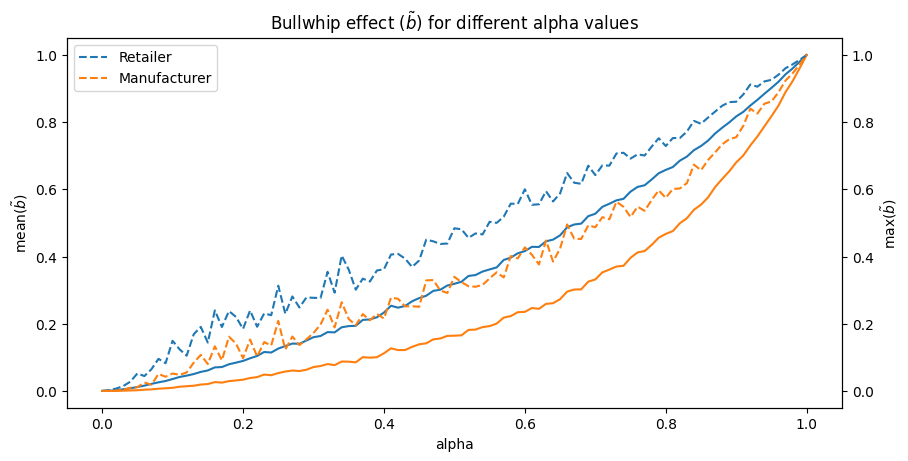

In [32]:
# Plot mean values of alpha
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.set_xlabel("alpha")

retailer_mean = [np.mean(bullwhip_effect[alpha, "retailer"]) for alpha in alpha_values]
manufacturer_mean = [
    np.mean(bullwhip_effect[alpha, "manufacturer"]) for alpha in alpha_values
]

ax1.plot(alpha_values, retailer_mean, label="Retailer")
ax1.plot(alpha_values, manufacturer_mean, label="Manufacturer")
ax1.set_ylabel(r"mean($\tilde{b}$)")

# Add second y-axis with max values
ax2 = ax1.twinx()

retailer_max = [np.max(bullwhip_effect[alpha, "retailer"]) for alpha in alpha_values]
manufacturer_max = [
    np.max(bullwhip_effect[alpha, "manufacturer"]) for alpha in alpha_values
]

ax2.plot(alpha_values, retailer_max, label="Retailer", linestyle="--")
ax2.plot(alpha_values, manufacturer_max, label="Manufacturer", linestyle="--")
ax2.set_ylabel(r"max($\tilde{b}$)")

plt.legend()
plt.title(r"Bullwhip effect ($\tilde{b}$) for different alpha values")

In the above graph we can see that we do not see a bullwhip effect for any alpha value. The reason for this is simple; the stage "managers" are rational, and thus do not over or under react to demand changes, which is what causes the bullwhip effect. The ratio $\tilde{b}$ is not significantly higher than 1, as a matter of fact the maximum $\tilde{b}$, which we get for $\alpha = 1$ is because we are reacting exactly to the demand.

## Organizing Supply Chain Coordination under MTO or MTS

**4a. What is the system’s optimal production quantity and expected profit under coordination or full partnership?** 

In terms of parameters we have: <br> 
◦ cost per unit: $c$=20  <br> 
◦ price per unit: $r$=50 <br> 
◦ salvage per unit: $v$=10<br> 
◦ holding cost per unit: $h$=$c$-$v$=10 <br> 
◦ stockout cost per unit: $p$=$r$-$c$=30 <br> 
<br>
Critical ratio: <br> 
$$
\begin{align*}
CR &= \frac{r-c}{r-v} \\
        &= \frac{50-20}{50-10} \\
        &= 0.75
\end{align*}
$$
<br>
Using the table given to use we find the CDF, $F(Q)$  <br>

| Demand | Probability | F(Q)|
|----------|----------|----------|
|  2000    | 3%       | 0.03  |
|  2100    | 8%       | 0.11  |
|  2200    | 15%      | 0.25  |
|  2300    | 30%      | 0.56  |
|  2400    | 17%      | 0.73  |
|  2500    | 12%      | 0.85  |
|  2600    | 10%      | 0.95  |
| 2700     | 5%       | 1.00  |

<br>
Using the critical ratio and the table we see that $F(Q)=0.75$ lies between 2400 and 2500. The rounding techniques discussed in the book lead us to the conclusion that $Q^{*}_{o}=2400$.


To find the expected profit under full cooperation we use the discretized formula: 
$$
\pi_{o} = \sum_{D} P(D)[min(D,Q^{*})\cdot r - Q^{*} \cdot c + max(0,Q^{*}-D)\cdot v]
$$
Recursively plugging the parameters into this formula: <br> 

$D=2000, P(D)=0.03$ 
$$
\begin{align*}
\pi_{1} &= 0.03[\min(2000,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2000)\cdot 10] \\
        &= 1,680
\end{align*}
$$
$D=2100, P(D)=0.08$ 
$$
\begin{align*}
\pi_{2} &= 0.08[\min(2100,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2100)\cdot 10] \\
        &= 4,800
\end{align*}
$$
$D=2200, P(D)=0.15$ 
$$
\begin{align*}
\pi_{3} &= 0.15[\min(2200,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2200)\cdot 10] \\
        &= 9,600
\end{align*}
$$
$D=2300, P(D)=0.3$ 
$$
\begin{align*}
\pi_{4} &= 0.3[\min(2300,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2300)\cdot 10] \\
        &= 20,400
\end{align*}
$$
$D=2400, P(D)=0.17$ 
$$
\begin{align*}
\pi_{5} &= 0.17[\min(2400,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2400)\cdot 10] \\
        &= 12,240
\end{align*}
$$
$D=2500, P(D)=0.12$ 
$$
\begin{align*}
\pi_{6} &= 0.12[\min(2500,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2500)\cdot 10] \\
        &= 8,640
\end{align*}
$$
$D=2600, P(D)=0.10$ 
$$
\begin{align*}
\pi_{7} &= 0.10[\min(2600,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2600)\cdot 10] \\
        &= 7,200
\end{align*}
$$
$D=2700, P(D)=0.05$ 
$$
\begin{align*}
\pi_{8} &= 0.05[\min(2700,2400)\cdot 50 - 2400 \cdot 20 + \max(0,2400-2700)\cdot 10] \\
        &= 3,600
\end{align*}
$$
< br > 
The total profit is 
$$
\begin{align*}
\pi_{o} &= \pi_{1} + \pi_{2} + \pi_{3} + \pi_{4} + \pi_{5} + \pi_{6} + \pi_{7} + \pi_{8} \\
        &= 68,160
\end{align*}
$$ 
So the total expected profit for optimal production $Q^{*}_{o} = 2400 $ is €68,160. 

**4b. Suppose the timing of events is as follows: <br>
◦ The distributor orders before it receives demand from end customers. <br>
◦ The manufacturer produces the amount ordered by the distributor. <br>
◦ Customer demand is observed. <br>
Is the manufacturer acting make-to-order (MTO) or make-to-stock (MTS)?** <br>

Using the information provided by 6.4 of the textbook, we find that the manufacturer is acting make-to-order (MTO). From the event we see that the manufacturer only begins production after recieving order an order from the distributer. The customer demand is observed downsteam and the manufacterer does not produce inventory in anticipation of future demand. Based on this we conclude that the manufacturer holds no inventory and that demand triggers the production process, whereas made-to-stock (MTS) production is based on a demand forecast and anticipates customer demand. 

**4c. Suppose the manufacturer sells to the distributor at AC40/unit (wholesale price contract); how much should the distributor order? What is the expected profit for the manufacturer? What is the expected profit for the distributor?**

In terms of parameters we have: <br> 
◦ cost per unit: $c$=20  <br> 
◦ price per unit: $r$=50 <br> 
◦ salvage per unit: $v$=10<br> 
◦ wholesale price per unit: $w$=40<br> 
<br>
Critical ratio: <br> 
$$
\begin{align*}
CR &= \frac{r-w}{r-v} \\
        &= \frac{50-40}{50-10} \\
        &= 0.25
\end{align*}
$$
<br>
Using the table given to use we find the CDF, $F(Q)$  <br>

| Demand | Probability | F(Q)|
|----------|----------|----------|
|  2000    | 3%       | 0.03  |
|  2100    | 8%       | 0.11  |
|  2200    | 15%      | 0.25  |
|  2300    | 30%      | 0.56  |
|  2400    | 17%      | 0.73  |
|  2500    | 12%      | 0.85  |
|  2600    | 10%      | 0.95  |
| 2700     | 5%       | 1.00  |

<br>
Using the critical ratio and the table we see that $F(Q)=0.25$ lies between 2200 and 2300. The rounding techniques discussed in the book lead us to the conclusion that $Q^{*}_{d}=2200$.

To find the expected profit for the distributer we use the discretized formula: 
$$
\pi_d = \sum_{D} P(D)[min(Q^{*},D)\cdot (r-w) - max(0,Q^{*}-D)\cdot (w-v)]
$$
Recursively plugging the parameters into this formula: <br> 
<br>
$D=2000, P(D)=0.03$ 
$$
\begin{align*}
\pi_{1} &= 0.03[\min(2200,2000)\cdot (50-40) - \max(0,2200-2000)\cdot (40-10)] \\
        &= 780
\end{align*}
$$
$D=2100, P(D)=0.08$ 
$$
\begin{align*}
\pi_{2} &= 0.08[\min(2200,2100)\cdot (50-40) - \max(0,2200-2100)\cdot 10] \\
        &= 1,920
\end{align*}
$$
$D=2200, P(D)=0.15$ 
$$
\begin{align*}
\pi_{3} &= 0.15[\min(2200,2200)\cdot(50-40) - \max(0,2200-2200)\cdot 10] \\
        &= 3,300
\end{align*}
$$
$D=2300, P(D)=0.3$ 
$$
\begin{align*}
\pi_{4} &= 0.3[\min(2200,2300)\cdot(50-40) - \max(0,2200-2300)\cdot 10] \\
        &= 6,600
\end{align*}
$$
$D=2400, P(D)=0.17$ 
$$
\begin{align*}
\pi_{5} &= 0.17[\min(2200,2400)\cdot (50-40) - \max(0,2200-2400)\cdot 10] \\
        &= 3,740
\end{align*}
$$
$D=2500, P(D)=0.12$ 
$$
\begin{align*}
\pi_{6} &= 0.12[\min(2200,2500)\cdot (50-40) - \max(0,2200-2500)\cdot 10] \\
        &= 2,640
\end{align*}
$$
$D=2600, P(D)=0.10$ 
$$
\begin{align*}
\pi_{7} &= 0.10[\min(2200,2600)\cdot (50-40) - \max(0,2200-2600)\cdot 10] \\
        &= 2,200
\end{align*}
$$
$D=2700, P(D)=0.05$ 
$$
\begin{align*}
\pi_{8} &= 0.05[\min(2200,2700)\cdot (50-40) - \max(0,2200-2700)\cdot 10] \\
        &= 1,100
\end{align*}
$$
The total profit is 
$$
\begin{align*}
\pi_{d} &= \pi_{1} + \pi_{2} + \pi_{3} + \pi_{4} + \pi_{5} + \pi_{6} + \pi_{7} + \pi_{8} \\
        &= 22,280
\end{align*}
$$ 

So the total expected profit for optimal production $Q^{*}_{d} = 2400 $ is €22,280. 

**4d. Find an option contract (essentially a quantity flexibility contract) such that both the manufacturer and distributor enjoy a higher expected profit than 4b. What is the expected profit for the manufacturer and the distributor now?**

The transfer payment for the quantity flexbility contract is 
$$
\begin{align*}
T_{q}(Q,w,\delta) &= wQ - (w+c_{r}-v)[\int_{0}^{(1-\delta)Q} \delta Qf(d)dd \int_{1-\delta}^{Q} (Q-d)f(d)dd]\\
        &= wQ - (w+c_{r}-v) \int_{
\end{align*}
$$
